In [1]:
## requirements
# conda install --file env/byoml_pytorch.environment.yml
# conda activate byoml_pytorch 
# pip install -r env/byoml_pytorch.requirements.txt

In [2]:
# notebook parameters, cell requires a `parameters` tag
INPUT_WINDOW = 24 # one year of data
TEST_DATA_SIZE = 36 # keep away from model training
MODEL_NAME = 'pytorch-example'

## PyTorch example

In this notebook we show how you can create and upload a PyTorch model to Waylay using TorchScript. 

PyTorch up to version 1.5 is supported! First let's import a dataset:

In [3]:
import seaborn as sns
import pandas as pd

passengers                                                       
month        Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
year                                                                   
1949         112  118  132  129  121  135  148  148  136  119  104  118
1950         115  126  141  135  125  149  170  170  158  133  114  140
1951         145  150  178  163  172  178  199  199  184  162  146  166
1952         171  180  193  181  183  218  230  242  209  191  172  194
1953         196  196  236  235  229  243  264  272  237  211  180  201
1954         204  188  235  227  234  264  302  293  259  229  203  229
1955         242  233  267  269  270  315  364  347  312  274  237  278
1956         284  277  317  313  318  374  413  405  355  306  271  306
1957         315  301  356  348  355  422  465  467  404  347  305  336
1958         340  318  362  348  363  435  491  505  404  359  310  337
1959         360  342  406  396  420  472  548  559  463  407  362  405
1960         417  391  419  461  472  535  622  606  508  461  390  432

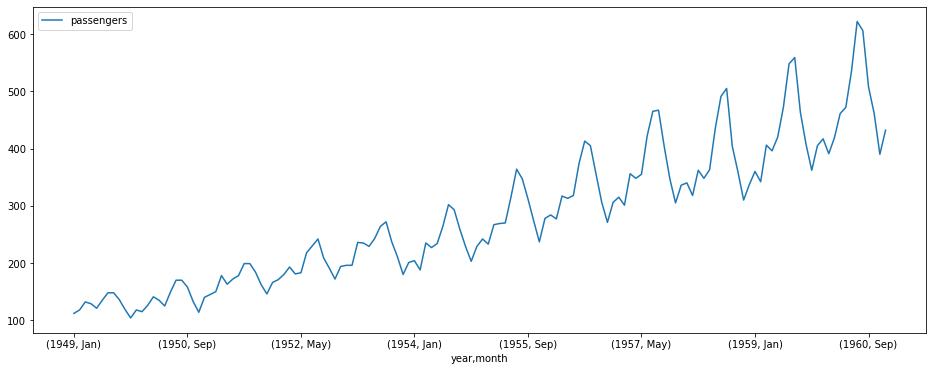

In [4]:
df = sns.load_dataset('flights')
df = df.set_index(['year', 'month'])
df.plot(figsize=(16,6))
df.unstack('month')

In [5]:
import torch

In [6]:
def create_X_y(input_data, input_window=INPUT_WINDOW):
    t_input = torch.FloatTensor(input_data)
    t_features = torch.as_strided(t_input, (len(t_input)-input_window, input_window), (1,1))
    t_labels = t_input[input_window:]
    return t_features, t_labels

In [7]:
train_data = df.iloc[:-TEST_DATA_SIZE,0]
test_data = df.iloc[-TEST_DATA_SIZE:,0]

In [8]:
X_train, y_train = create_X_y(train_data.to_list())
X_test, y_test = create_X_y(test_data.to_list())

In [9]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4)

Now we can create the model, a simple one with only one LSTM layer:

In [10]:
class PassengerModel(torch.nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = torch.nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        self.linear = torch.nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(1, x.size(0), self.hidden_layer_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_layer_size)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x.view(x.size(0), x.size(1), 1).float(), (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.linear(out[:, -1, :])
        return out.flatten()

In [11]:
model = PassengerModel()
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
epochs = 2000

for i in range(epochs):
    running_loss = 0.0
    for j, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_function(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if i%100 == 0:
        print(f'epoch: {i:3} loss: {running_loss/len(train_loader):10.8f}')
    running_loss = 0.0

print(f'epoch: {i:3} loss: {loss.item():10.10f}')

epoch:   0 loss: 72314.52176339
epoch: 100 loss: 18511.45583961
epoch: 200 loss: 6784.96791149
epoch: 300 loss: 2889.10846638
epoch: 400 loss: 1205.99573117
epoch: 500 loss: 724.12303661
epoch: 600 loss: 536.45974513
epoch: 700 loss: 441.46906571
epoch: 800 loss: 336.16394370
epoch: 900 loss: 282.05184482
epoch: 1000 loss: 226.27227384
epoch: 1100 loss: 199.67105339
epoch: 1200 loss: 179.29517110
epoch: 1300 loss: 286.06669626
epoch: 1400 loss: 218.77638426
epoch: 1500 loss: 184.45284707
epoch: 1600 loss: 151.40734055
epoch: 1700 loss: 153.73339916
epoch: 1800 loss: 147.06312507
epoch: 1900 loss: 106.31506815
epoch: 1999 loss: 33.6877288818


Let's validate if the model learned something:

In [13]:
import numpy as np

<AxesSubplot:xlabel='year,month'>

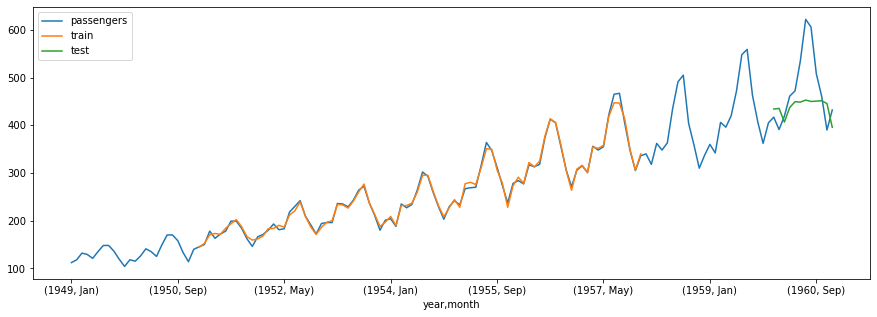

In [28]:
df_pred = df.copy()

train_preds = model(X_train).tolist()
df_pred['train'] = np.NaN
df_pred.iloc[INPUT_WINDOW:INPUT_WINDOW+len(train_preds),1] = train_preds

test_pred_offset = len(df) - TEST_DATA_SIZE + INPUT_WINDOW
test_preds = model(X_test).tolist()
df_pred['test'] = np.NaN
df_pred.iloc[test_pred_offset:test_pred_offset+len(test_preds),2] = test_preds
df_pred.plot(figsize=(15, 5))

## Save the model and upload 

We will compile the model using TorchScript, for more information, check https://pytorch.org/docs/stable/jit.html#torch.jit.save

In [29]:
from waylay import WaylayClient, RestResponseError
waylay = WaylayClient.from_profile()

In [30]:
import time
# clean up existing model
try:
    waylay.byoml.model.remove(MODEL_NAME)
    time.sleep(10)
    display(f'Removed: {MODEL_NAME}')
except RestResponseError as e:
    display(f'Ignored: {e}')

"Ignored: ByomlActionError(404: 'Model does not exist'; DELETE 'https://byom-staging.waylay.io/models/pytorch-example')"

And now upload it to Waylay:

In [31]:
result = waylay.byoml.model.upload(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='pytorch', 
    description='pytorch example'
)
result

{'message': 'Model successfully uploaded'}

In [32]:
waylay.byoml.model.get(MODEL_NAME)

{'createdBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'createdOn': '2021-06-10T12:41:34.790305+00:00',
 'description': 'pytorch example',
 'framework': 'pytorch',
 'name': 'pytorch-example',
 'supported_endpoints': ['predict'],
 'updatedBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'updatedOn': '2021-06-10T12:41:34.790367+00:00'}

In [33]:
features = X_test.tolist()
result = waylay.byoml.model.predict(MODEL_NAME, features)
        
result

array([433.99246216, 435.30426025, 406.67407227, 437.24255371,
       449.34744263, 448.48800659, 452.77542114, 449.8800354 ,
       450.50247192, 451.44473267, 445.50457764, 395.58511353])

<AxesSubplot:xlabel='year,month'>

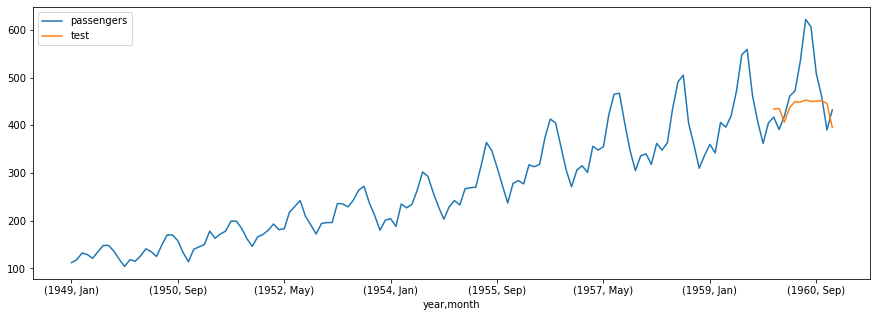

In [34]:
df_pred = df.copy()
df_pred['test'] = np.NaN
df_pred.iloc[test_pred_offset:,1] = result
df_pred.plot(figsize=(15, 5))

<AxesSubplot:xlabel='year,month'>

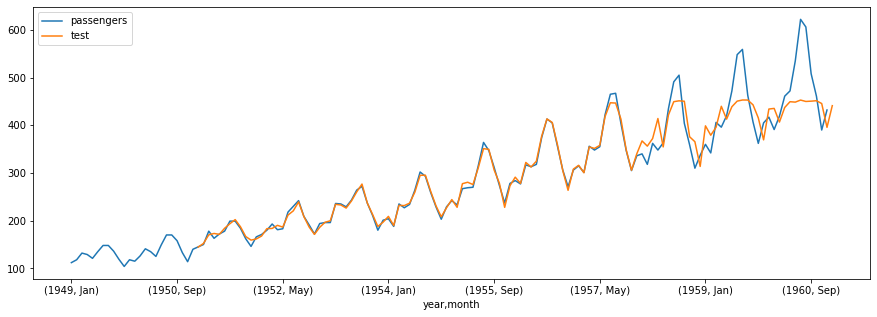

In [35]:
input_data = df.loc[:,'passengers'].to_list()

all_features, _ = create_X_y(input_data)
preds = waylay.byoml.model.predict(MODEL_NAME, all_features.tolist())
df_pred = df.copy()
df_pred['test'] = np.NaN
df_pred.iloc[INPUT_WINDOW:INPUT_WINDOW+len(preds),1] = preds

# prediction for Jan 1961
feat_jan_1961 = df.iloc[-INPUT_WINDOW:, 0].to_list()
df_pred.loc[((1961,'Jan')),'test'] = waylay.byoml.model.predict(MODEL_NAME, [feat_jan_1961])[0]


df_pred.plot(figsize=(15, 5))

In [36]:
waylay.byoml.model.remove(MODEL_NAME)

{'message': 'Model successfully deleted'}

## More advanced TorchScript

In the example above we uploaded the model straight away, but if we want to add some pre- or postprocessing, we can also use TorchScript for this.

In this example we do the sliding window feature extraction in the model itself.

In [37]:
example_input = X_test[:4]

class MyScriptModule(torch.jit.ScriptModule):
    __constants__ = ['window']
    
    def __init__(self, window=INPUT_WINDOW):
        super(MyScriptModule, self).__init__()
        self.model = torch.jit.trace(model, example_input)
        self.window = window

    @torch.jit.script_method
    def forward(self, inputs):
        features = torch.as_strided(inputs, (len(inputs)-self.window+1, self.window), (1,1))
        return self.model(features)

In [38]:
script_model = MyScriptModule(INPUT_WINDOW)

In [39]:
all_data = df.iloc[:,0].to_list()
script_model(torch.FloatTensor(all_data))

tensor([144.6380, 152.1951, 170.2333, 173.1504, 171.2736, 184.0639, 193.5846,
        202.1937, 187.2209, 166.6897, 159.2139, 161.6323, 167.8044, 183.2392,
        183.6612, 190.1622, 186.4776, 211.7158, 220.5595, 239.2952, 208.6028,
        186.5755, 171.2462, 186.0768, 196.5771, 199.7640, 234.2001, 232.8518,
        226.3857, 241.1160, 260.2211, 276.7041, 237.0510, 213.1760, 187.7912,
        196.8943, 208.9409, 189.7966, 231.9729, 231.5949, 236.6287, 259.6121,
        295.0287, 295.2916, 261.4766, 231.1507, 208.1043, 226.9811, 244.1698,
        227.9915, 277.4724, 280.5207, 275.6813, 310.5559, 350.9122, 349.4828,
        306.5275, 278.4146, 227.9007, 273.0826, 291.1522, 278.1183, 322.0680,
        312.5727, 324.7224, 376.9096, 413.2713, 405.7993, 358.7937, 304.8711,
        263.6260, 308.0346, 316.0373, 300.4729, 354.4989, 351.5027, 357.8352,
        418.2701, 447.1187, 446.5329, 412.9775, 348.6168, 305.6920, 340.0255,
        367.1560, 356.2336, 372.1469, 414.1056, 354.5966, 421.74

In [40]:
result = waylay.byoml.model.upload(
    model_name=MODEL_NAME_ADVANCED, 
    trained_model=script_model, 
    framework='pytorch', 
    description='pytorch example'
)
result

{'message': 'Model successfully uploaded'}

<AxesSubplot:xlabel='year,month'>

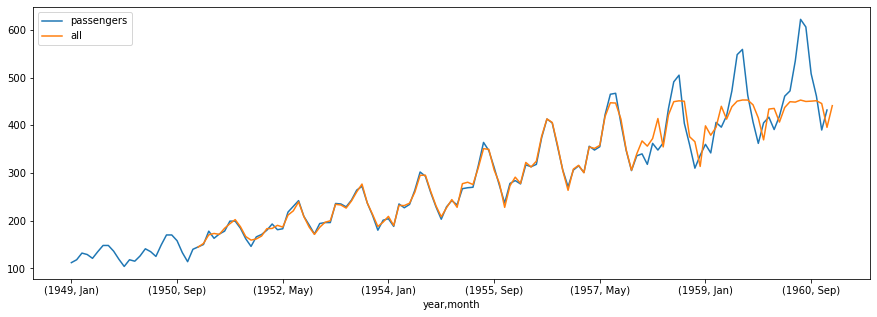

In [41]:
preds = waylay.byoml.model.predict(MODEL_NAME_ADVANCED, all_data)

df_pred = df.copy()
df_pred['all'] = np.NaN
df_pred.loc[((1961,'Jan')),'all'] = np.NaN
df_pred.iloc[INPUT_WINDOW:INPUT_WINDOW+len(preds),1] = preds
df_pred.plot(figsize=(15, 5))

In [27]:
waylay.byoml.model.remove(MODEL_NAME_ADVANCED)

{'message': 'Model successfully deleted'}